# 頑健性 検証用データセットの作成

## ノードサイズ依存性の検証
リサイズを固定し、ノードサイズが大きくなっていくに連れて精度はどう変化するのかを検証  
-> 横軸 : ノード数, 縦軸 : 精度

### poisson のパラメータ乱数
- BA 平均 5 分散 3
- Growth 平均 5 分散 3
- Attach 平均 500 分散 100
- Random 平均 0.09 分散 0.03

### 検証用データセット
node 50, 100, 300, 500, 1000, 2000, 5000  
各ノード数で1000個作成.  
パラメータの乱数範囲はpoissonと同様にする設定

In [2]:
import os
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
import pandas as pd

from test_utils import network_info
from reserch_utils_HT import network_to_image
from reserch_utils_HT import no_growth, no_preferential_attachment
from torch_geometric.utils import from_networkx

# ヒートマップ用データセット作成

In [3]:
def robustness(kind):
    def attach_params(n):
        return [n*.1, n*.25, n*.5, n*.75, n, n*2, n*3, n*4, n*8, n*10, n*15]
    
    
    kind_to_index = {"BA": 0, "Attach": 1, "Growth": 2, "Random": 3}
    
    nodes = [20,30,50,70,100,130,200,300,500,1000,2000]
    
        
    for node in tqdm(nodes):
        acc_dict = {} # 結果保存用 辞書 (key: node, value: 精度)
        
        # parameters
        if kind in ["BA", "Growth"]:
            if node >= 50:
                params = [1,2,4,6,8,10,15,20,30,40]
            elif node == 30:
                params = [1,2,4,6,8,10,15,20]
            elif node == 20:
                params = [1,2,4,6,8,10]
            else:
                params = [1,2,4,6,8,10,15,20]
                
        elif kind == "Attach":
            params = attach_params(node)
        else:
            params = [0.01, 0.02, 0.05, 0.07, 0.1, 0.15, 0.2]
        
        for m in params:
            cnt = 0
            os.makedirs(f"./robustness_data_graph/{kind}/{node}/{m}", exist_ok=True)
            os.makedirs(f"./robustness_data_img/{kind}/{node}/{m}", exist_ok=True)
            
            os.makedirs(f"./robustness_data_tensor/{kind}/{node}/{m}/edge", exist_ok=True)
            os.makedirs(f"./robustness_data_tensor/{kind}/{node}/{m}/x", exist_ok=True)
            os.makedirs(f"./robustness_data_tensor/{kind}/{node}/{m}/y", exist_ok=True)
            
            
            # make data
            for i in range(50):
                if kind == "BA":
                    G = nx.barabasi_albert_graph(node, m, seed=10000+i)
                elif kind == "Attach":
                    G = no_growth(node, m, seed=10000+i)
                elif kind == "Growth":
                    G = no_preferential_attachment(node, m, seed=10000+i)
                else:
                    G = nx.gnp_random_graph(node, m, seed=10000+i)
                
                nx.write_adjlist(G, f"./robustness_data_graph/{kind}/{node}/{m}/{i}.adjlist")
                
                img = network_to_image(G, sort=True)
                img.save(f"./robustness_data_img/{kind}/{node}/{m}/{i}.png")
                
                data_tensor = graph_to_geometricTensor(G, kind)
                torch.save(data_tensor.edge_index, f"./robustness_data_tensor/{kind}/{node}/{m}/edge/{i}.pt")
                torch.save(data_tensor.x, f"./robustness_data_tensor/{kind}/{node}/{m}/x/{i}.pt")    
                torch.save(data_tensor.y, f"./robustness_data_tensor/{kind}/{node}/{m}/y/{i}.pt")
                
                
                del G
                del img

In [1]:

def graph_to_geometricTensor(G, kind):
    """ graph -> GNN用データ 変換"""
    kind_to_label = {"BA": 0, "Attach": 1, "Growth": 2, "Random": 3}
    # graph to torch geometric data
    data = from_networkx(G)

    # set node attribute
    data.x = torch.tensor(
        [[d] for d in list(dict(G.degree()).values())],
        dtype=torch.float,
    )
    # set graph label
    data.y = torch.tensor([kind_to_label[kind]])
    return data

In [5]:
robustness("BA")
robustness("Attach")
robustness("Growth")
robustness("Random")

100%|██████████| 11/11 [15:08<00:00, 82.57s/it] 


In [ ]:
# robustness data info

In [6]:
def ba_growth_param(n):
    if n >= 50:
        params = [1,2,4,6,8,10,15,20,30,40]
    elif n == 30:
        params = [1,2,4,6,8,10,15,20]
    elif n == 20:
        params = [1,2,4,6,8,10]
    else:
        params = [1,2,4,6,8,10,15,20]
    return params

def attach_params(n):
    return [n*.1,n*.25,n*.5,n*.75,n,n*2,n*3,n*4,n*8,n*10,n*15]

def pred_there(model, data, class_index, thres):
    """ 閾値を超えて、予測が正解の数を返す """
    softmax = torch.nn.Softmax(1)
    with torch.no_grad():
        pred = softmax(model(data))
    index = pred.argmax(dim=1) # pred index
    count = (pred[index == class_index][:, class_index] > thres).sum().item() # 閾値を超え 且つ 予想が正解 した数
    return count

def robust_acc_df(kind):
    kind_to_index = {"BA": 0, "Attach": 1, "Growth": 2, "Random": 3}
    df = pd.DataFrame()
    cnt = 0
    for n in tqdm([20,30,50,70,100,130,200,300,500,1000,2000]):
        kind_to_parameters = {
            "BA": ba_growth_param(n),
            "Growth": ba_growth_param(n),
            "Attach": attach_params(n),
            "Random": [0.01, 0.02, 0.05, 0.07, 0.1, 0.15, 0.2]
        }

        for param_index, p in enumerate(kind_to_parameters[kind]):
            # network to torch tensor
            for i, path in enumerate(glob(f"./robustness_data_graph/{kind}/{n}/{p}/*")):
                G = nx.read_adjlist(path)
                info = network_info(G)
                info["kind"] = kind
                info["parameter"] = p
                info["node"] = n
                df = df.append(pd.Series(info, name=cnt))
                cnt += 1
    return df


def make_heatmap(dataset_name, resize, gpu=True):
    # load model
    model = CNN_base("CNN", 4, resize)
    model_path = f"../logs/{dataset_name}/CNN/sort_{resize}_0.001/model_weight/fold0_trial0_epoch10.pth"
    if gpu:
        model.load_state_dict(torch.load(model_path))
    else:
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    
    # make acc dataframe
    ba = robust_acc_df(model, resize, "BA")
    attach = robust_acc_df(model, resize, "Attach")
    growth = robust_acc_df(model, resize, "Growth") 
    random = robust_acc_df(model, resize, "Random")
    
    ba.to_csv(f"./robustness_plot/acc_df/CNN_BA_{dataset_name}_{resize}.csv")
    attach.to_csv(f"./robustness_plot/acc_df/CNN_Attach_{dataset_name}_{resize}.csv")
    growth.to_csv(f"./robustness_plot/acc_df/CNN_Growth_{dataset_name}_{resize}.csv")
    random.to_csv(f"./robustness_plot/acc_df/CNN_Random_{dataset_name}_{resize}.csv")

# 改良

In [3]:
def make_graph(kind, node, m, i):
    if kind == "BA":
        G = nx.barabasi_albert_graph(node, m, seed=10000+i)
    elif kind == "Attach":
        G = no_growth(node, m, seed=10000+i)
    elif kind == "Growth":
        G = no_preferential_attachment(node, m, seed=10000+i)
    else:
        G = nx.gnp_random_graph(node, m, seed=10000+i)
    return G

def net_info(G, kind, parameter, i):
    """ ノード数, エッジ数, 平均次数 """
    degs = list(dict(G.degree).values())
    info = {"node": nx.number_of_nodes(G),
            "edges": nx.number_of_edges(G),
            "average": np.average(degs),
            "kind": kind,
            "parameter": parameter,
            "seed" : i+10000
           }
    return info

def save_graph_img_tensor(G, kind, node, parameter, i):
    # graph
    nx.write_adjlist(G, f"./robustness_data_graph/{kind}/{node}/{parameter}/{i}.adjlist")
    # image
    img = network_to_image(G, sort=True)
    img.save(f"./robustness_data_img/{kind}/{node}/{parameter}/{i}.png")
    del img
    # tensor
    data_tensor = graph_to_geometricTensor(G, kind)
    torch.save(data_tensor.edge_index, f"./robustness_data_tensor/{kind}/{node}/{parameter}/edge/{i}.pt")
    torch.save(data_tensor.x, f"./robustness_data_tensor/{kind}/{node}/{parameter}/x/{i}.pt")    
    torch.save(data_tensor.y, f"./robustness_data_tensor/{kind}/{node}/{parameter}/y/{i}.pt")
    del data_tensor

In [4]:
parameter = {
    "BA": {
        20 : [1,2,3,4,5,6,7,8,9,10],
        30 : [1,2,3,4,5,6,7,8,9,10],
        50 : [1,2,3,4,5,6,7,8,9,10],
        70 : [1,2,3,4,5,6,7,8,9,10],
        100: [1,2,3,4,5,6,7,8,9,10,15,20,25,30],
        200: [1,2,3,4,5,6,7,8,9,10,15,20,25,30],
        300: [1,2,3,4,5,6,7,8,9,10,15,20,25,30],
        500: [1,2,3,4,5,6,7,8,9,10,15,20,25,30],
        700: [1,2,3,4,5,6,7,8,9,10,15,20,25,30],
        1000: [1,2,3,4,5,6,7,8,9,10,15,20,25,30,50,100,200],
        2000: [1,2,3,4,5,6,7,8,9,10,15,20,25,30,50,100,200]
    },
    "Growth": {
        20 : [1,2,3,4,5,6,7,8,9,10],
        30 : [1,2,3,4,5,6,7,8,9,10],
        50 : [1,2,3,4,5,6,7,8,9,10],
        70 : [1,2,3,4,5,6,7,8,9,10],
        100: [1,2,3,4,5,6,7,8,9,10,15,20,25,30],
        200: [1,2,3,4,5,6,7,8,9,10,15,20,25,30],
        300: [1,2,3,4,5,6,7,8,9,10,15,20,25,30],
        500: [1,2,3,4,5,6,7,8,9,10,15,20,25,30],
        700: [1,2,3,4,5,6,7,8,9,10,15,20,25,30],
        1000: [1,2,3,4,5,6,7,8,9,10,15,20,25,30,50,100,200],
        2000: [1,2,3,4,5,6,7,8,9,10,15,20,25,30,50,100,200]
    },
    "Attach":{
        20 : [20 * i for i in np.linspace(0.5, 25, 10)],
        30 : [30 * i for i in np.linspace(0.5, 25, 10)],
        50 : [50 * i for i in np.linspace(0.5, 25, 10)],
        70 : [70 * i for i in np.linspace(0.5, 25, 10)],
        
        100 : [100 * i for i in np.linspace(0.5, 25, 14)],
        200 : [200 * i for i in np.linspace(0.5, 25, 14)],
        300 : [300 * i for i in np.linspace(0.5, 25, 14)],
        500 : [500 * i for i in np.linspace(0.5, 25, 14)],
        700 : [700 * i for i in np.linspace(0.5, 25, 14)],
        1000 : [1000 * i for i in np.linspace(0.5, 25, 17)],
        2000 : [2000 * i for i in np.linspace(0.5, 25, 17)],
        
    },
    "Random": {
        20: np.logspace(-1.3, -0.1, 10),
        30: np.logspace(-1.3, -0.1, 10),
        50: np.logspace(-1.3, -0.1, 10),
        70: np.logspace(-1.3, -0.1, 10),
        100: np.logspace(-2, -0.7, 14),
        200: np.logspace(-2, -0.7, 14),
        300: np.logspace(-2, -0.7, 14),
        500: np.logspace(-2, -0.7, 14),
        700: np.logspace(-2, -0.7, 14),
        1000: np.logspace(-3., -0.9, 17),
        2000: np.logspace(-3., -0.9, 17)
    }
}

In [5]:
def robustness():
    kind_to_index = {"BA": 0, "Attach": 1, "Growth": 2, "Random": 3}
    
    nodes = [20,30,50,70,100,200,300,500,700,1000,2000]
    
    info_df = pd.DataFrame()
    # make data
    cnt = 0
    for kind in ["BA", "Attach", "Growth", "Random"]:
        print(kind)
        for node in tqdm(nodes):
            for p in parameter[kind][node]:
                if kind == "Attach":
                    p = int(p)
                
                os.makedirs(f"./robustness_data_graph/{kind}/{node}/{p}", exist_ok=True)
                os.makedirs(f"./robustness_data_img/{kind}/{node}/{p}", exist_ok=True)
                os.makedirs(f"./robustness_data_tensor/{kind}/{node}/{p}/edge", exist_ok=True)
                os.makedirs(f"./robustness_data_tensor/{kind}/{node}/{p}/x", exist_ok=True)
                os.makedirs(f"./robustness_data_tensor/{kind}/{node}/{p}/y", exist_ok=True)
                
                for i in range(100):
                    G = make_graph(kind, node, p, i)
                    save_graph_img_tensor(G, kind, node, p, i)
                    info_df = info_df.append(pd.Series(net_info(G, kind, p, i), name=cnt))

                    cnt+=1
    return info_df

In [6]:
info_df = robustness()
info_df.to_csv("./robustness_plot/robustness_info.csv")

  0%|          | 0/11 [00:00<?, ?it/s]

BA


  0%|          | 0/11 [00:00<?, ?it/s]

Attach


  0%|          | 0/11 [00:00<?, ?it/s]

Growth


  0%|          | 0/11 [00:00<?, ?it/s]

Random


100%|██████████| 11/11 [39:23<00:00, 214.87s/it]


<AxesSubplot:xlabel='node', ylabel='edges'>

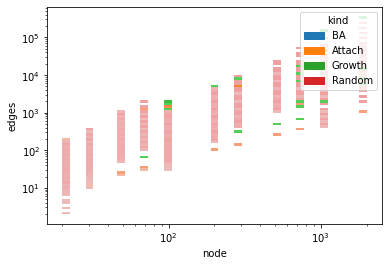

In [13]:
sns.histplot(data=info_df.query("edges>0"), x="node", y="edges", hue="kind", log_scale=(True,True))